# Retrieval Augmented Generation project for music recommendations based on Pitchfork.


We're building a Retrieval-Augmented Generation (RAG) system for conversational music recommendations to address limitations in current streaming platforms like Spotify. While these platforms generate recommendations through initial questionnaires, listening history, and user demographics, they don't allow direct conversational influence over suggestions, forcing users to manually search for occasion-specific playlists. Our goal is to create a chat-based assistant that leverages music review data to provide personalized recommendations through natural conversation, enabling users to ask for specific music needs (like "upbeat workout songs" or "melancholic indie music") and receive tailored suggestions based on review insights rather than purely algorithmic patterns.





In [2]:
!pip install accelerate #after this restart the session
!pip install -U bitsandbytes

In [3]:
!pip install openpyxl
!pip install seaborn

## Domain and dataset descripton


In this project as a domain we use the articles from [Pitchfork](https://pitchfork.com) - an online music publication portal. Each review on this website is written by one person (reviewer), that gives a total score for the album and analyzes its lyrics, vocals and instrumental part, usually linking it to some cultural background and previous works by particular musician.

The chosen dataset can be found on Kaggle [here](https://www.kaggle.com/datasets/timstafford/pitchfork-reviews?resource=download). This dataset is a collection of album reviews from early days of Pitchfork untill 2023 (included). The dataset contains features of different formats such us artist names, titles of the album, genre, dates, scores etc. Language of the reviews is English.

We firstly load the needed libraries and the dataset.

## Loading libraries and Preprocessing

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
import time
import transformers
import torch


In [5]:
# Load data
data_all = pd.read_excel("/kaggle/input/pitchfork-review/pitchfork_reviews.xlsx", sheet_name="Result 1")

In [6]:
data_all.head()

,artist,album,score,year,reviewer,genre,label,review_date,summary,review,best_new
0,Green-House,A Host for All Kinds of Life,7.6,2023,Hattie Lindert,Electronic / Experimental,Leaving,"October 23, 2023",The Los Angeles ambient musician continues to ...,For proof that we all must ultimately coexist ...,Not Available
1,Tkay Maidza,Sweet Justice,7.6,2023,Dylan Green,Pop/R&B,4AD,"November 3, 2023",The Australian musician chooses herself over t...,Tkay Maidza’s three-partLast Year Was WeirdEP ...,Not Available
2,A Giant Dog,Bite,6.4,2023,Linnie Greene,Rock,Merge,"August 28, 2023","On its first album in six years, the Austin gr...","A Giant Dog’sBite, the Austin, Texas, group’s ...",Not Available
3,Margaret Glaspy,Echo the Diamond,7.7,2023,Marc Hogan,Rock,ATO,"August 23, 2023","On her third album, the Brooklyn musician scra...",Margaret Glaspyhad only a couple of EPs to her...,Not Available
4,Maria BC,Spike Field,7.8,2023,Hannah Jocelyn,Rock / Experimental,Sacred Bones,"October 26, 2023","On their spectral new album, the Oakland music...","Since the 1980s, teams of engineers, anthropol...",Not Available


In [7]:
data_all.describe()

,artist,album,score,year,reviewer,genre,label,review_date,summary,review,best_new
count,25707,25707,25708,25708,25708,25708,25708,25708,25703,25107,25708
unique,11144,24177,102,65,635,151,7457,6232,24805,25085,3
top,Various Artists,Not Available,7.5,2007,Not Available,Rock,Not Available,Not Available,Not Available,"It was probably overstated, but a few years ag...",Not Available
freq,791,598,1321,1236,1860,8638,600,2945,850,2,24389


In [8]:
# Remove HTML: If reviews were scraped, they likely contain HTML tags. Use a library like BeautifulSoup
from bs4 import BeautifulSoup
def strip_html(text):
    if isinstance(text, str):
        soup = BeautifulSoup(text, "html.parser")
        return soup.get_text()
    return text
# Normalize Whitespace: Remove extra spaces, newlines, tabs.
def normalize_whitespace(text):
    if isinstance(text, str):
        return " ".join(text.split())
    return text

In [9]:
import numpy as np

# Replace "Not Available" with NaN
data_all.replace("Not Available", np.nan, inplace=True)
len(data_all)


25708

In [10]:
if 'best_new' in data_all.columns:
    # Convert potential string "True"/"False" or boolean True/False, and NaNs to a consistent boolean type.
    # NaNs (which came from "Not Available") will be treated as False.
    # If 'best_new' is already boolean and just has NaNs, fillna(False) is enough.
    # If it might contain strings 'True'/'False', a map can be more robust.
    # For simplicity, assuming it's either boolean, or NaN which means False for "Best New Music"
    data_all['best_new'] = data_all['best_new'].fillna(False).astype(bool)
    print("Processed 'best_new' column. NaNs filled with False, type converted to boolean.")
else:
    print("'best_new' column not found. Cannot process it.")

Processed 'best_new' column. NaNs filled with False, type converted to boolean.


In [11]:
print(data_all['genre'].value_counts(dropna=False))


genre
Rock                                    8638
Electronic                              2973
NaN                                     2945
Rap                                     2366
Pop/R&B                                 1695
                                        ... 
Global / Rap                               1
Rock / Experimental / Jazz                 1
Electronic / Global / Rap                  1
Global / Pop/R&B / Electronic / Rock       1
Experimental / Folk/Country / Jazz         1
Name: count, Length: 151, dtype: int64


In [12]:
len(data_all)

25708

As the number of data entries is relatively large, we limit the dataset to the articles from 2022-2023. So the overall result in principle should lead to a recommendation of an album of recent years.

We are also not interested in particular review date (only album's year), reviewer's name, 'best_new' column and label's name, which we drop from the datatset.

The cleaned version of the data we then save to a csv file that will be later loaded via LangChain's csv loader.

In [13]:
essential_cols = ['artist', 'album', 'review', 'score'] # Add 'summary' if it's a primary text source
data_all.dropna(subset=essential_cols, inplace=True)
data_all.drop_duplicates(subset=['artist', 'album'], inplace=True, keep='first')

In [14]:
data_all['genre'] = data_all['genre'].fillna("Unknown")


In [15]:
# 6. Drop other columns that are deemed unnecessary for the RAG model
# (keeping 'summary' as it's very useful, and 'best_new' is already handled)
columns_to_drop = ['reviewer', 'label', 'review_date']
# Check which of these columns actually exist before trying to drop
existing_columns_to_drop = [col for col in columns_to_drop if col in data_all.columns]
if existing_columns_to_drop:
    print(f"Dropping columns: {existing_columns_to_drop}")
    data_all.drop(columns=existing_columns_to_drop, inplace=True)
    print(f"Columns after dropping: {data_all.columns.tolist()}\n")
else:
    print("No specified unnecessary columns found to drop.\n")

Dropping columns: ['reviewer', 'label', 'review_date']
Columns after dropping: ['artist', 'album', 'score', 'year', 'genre', 'summary', 'review', 'best_new']



In [16]:

# Verify null counts for the remaining important columns
print("Null counts after cleaning:")
relevant_cols_for_null_check = ['artist', 'album', 'score', 'year', 'genre', 'summary', 'review', 'best_new']
existing_relevant_cols = [col for col in relevant_cols_for_null_check if col in data_all.columns]
if existing_relevant_cols:
    print(data_all[existing_relevant_cols].isnull().sum())
else:
    print("No relevant columns found for null check (this is unexpected).")
print("\n")

Null counts after cleaning:
artist        0
album         0
score         0
year        410
genre         0
summary     253
review        0
best_new      0
dtype: int64




In [17]:
data_all = data_all.dropna(subset=['review'])
data_all = data_all.dropna(subset=['year'])
data_all['review'] = data_all['review'].apply(strip_html)
data_all['review'] = data_all['review'].apply(normalize_whitespace)

In [18]:
data_all.columns

Index(['artist', 'album', 'score', 'year', 'genre', 'summary', 'review',
       'best_new'],
      dtype='object')

In [19]:
data = data_all.replace([np.inf, -np.inf], np.nan)

Now we can have a look at the descriptive statistics of the dataset.

### 1) Number of data entries

In [20]:
print(len(data))

24631


In [21]:
pip install --upgrade seaborn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 7.2 MB/s eta 0:00:00ta 0:00:01
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.12.2
    Uninstalling seaborn-0.12.2:
      Successfully uninstalled seaborn-0.12.2
Note: you may need to restart the kernel to use updated packages.


### 2) Distribution and statistical description of the reviews' lengths in characters.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


Text(0, 0.5, 'Frequency')

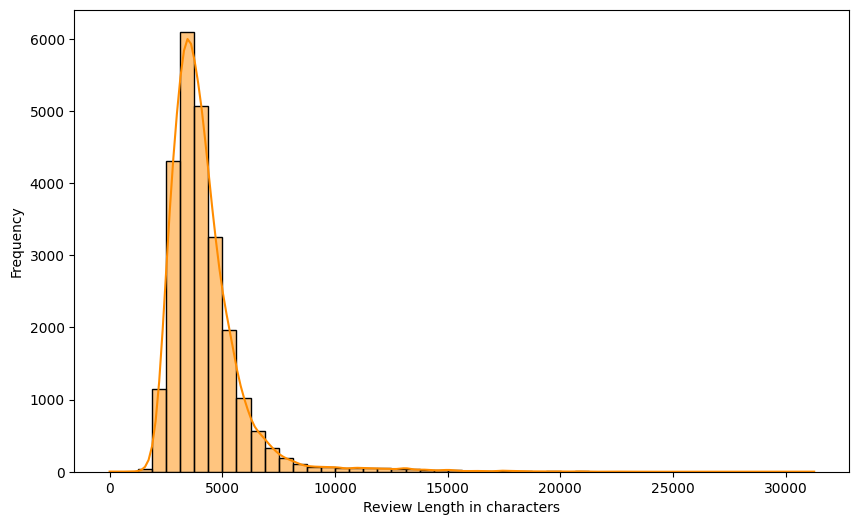

In [22]:

data['review_length'] = data['review'].str.len()

plt.figure(figsize=(10, 6))
sns.histplot(data['review_length'], kde=True, bins=50, color='darkorange')
plt.xlabel('Review Length in characters')
plt.ylabel('Frequency')

In [23]:
print(data["review_length"].describe())

count    24631.000000
mean      4188.425683
std       1725.185807
min          1.000000
25%       3199.000000
50%       3834.000000
75%       4683.000000
max      31270.000000
Name: review_length, dtype: float64


### 3) Distribution of published articles throughout the years

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


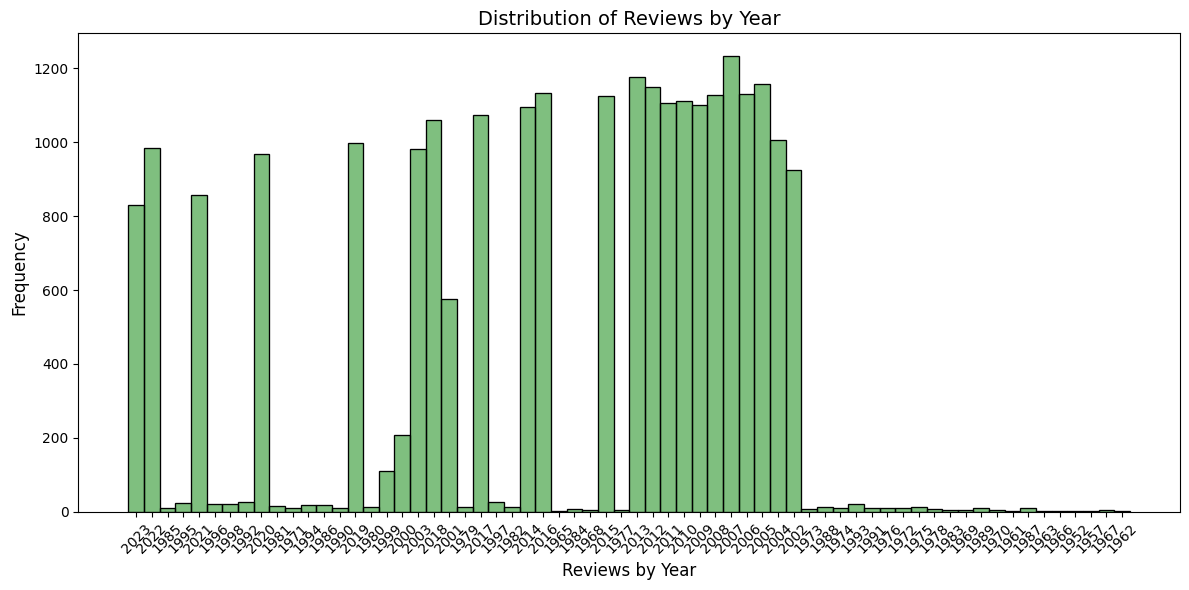

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))  # Adjust figure size for better readability
sns.histplot(data['year'], bins=20, color='green', alpha=0.5)  # Increase bins for better granularity
plt.xlabel('Reviews by Year', fontsize=12)  # Add a clear x-axis label
plt.ylabel('Frequency', fontsize=12)  # Add a clear y-axis label
plt.title('Distribution of Reviews by Year', fontsize=14)  # Add a title

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.show()

### 4) Distribution by music


As it can be seen from the plot below, the two most popular genre of albums considered in reviews are Pop/R&B, Rap and Rock.

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  """Call fig.tight_layout within rect that exclude the legend."""


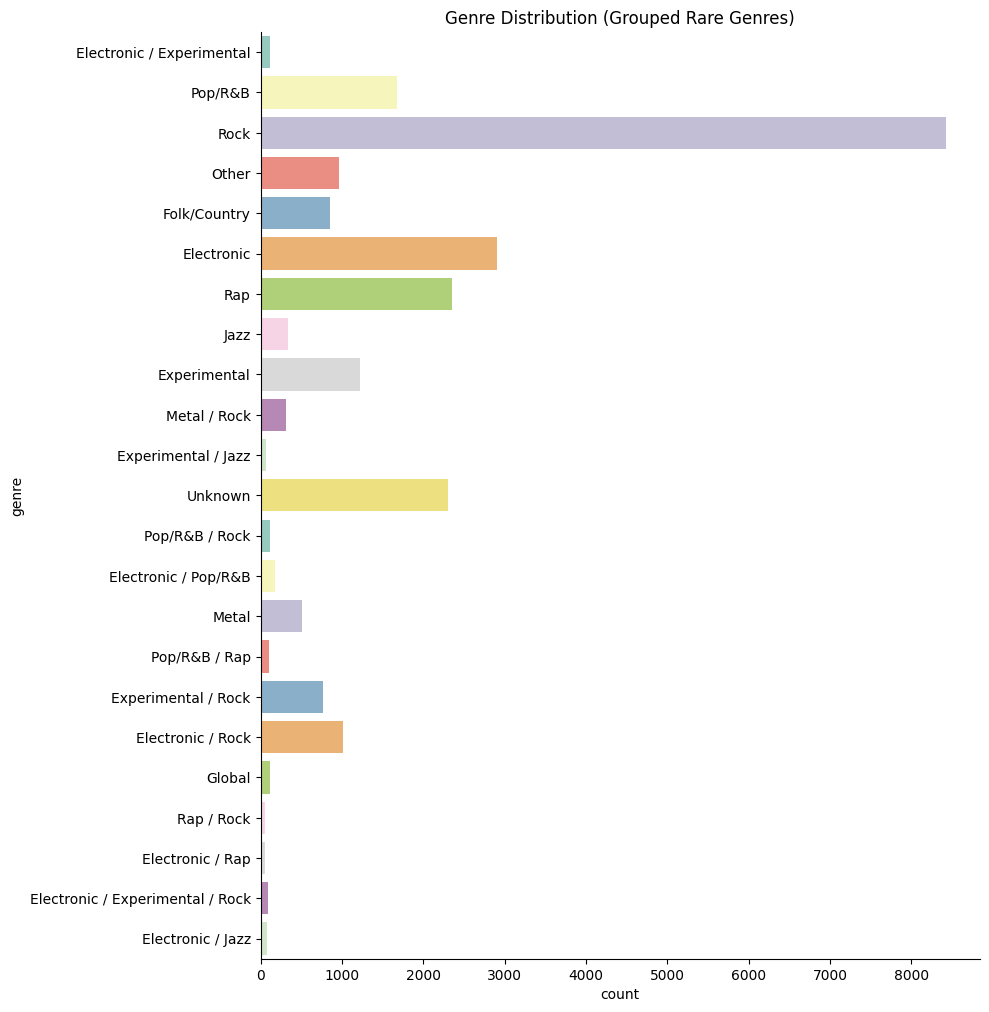

In [25]:
# Count the occurrences of each genre
genre_counts = data['genre'].value_counts()

# Define a threshold for grouping less frequent genres
threshold = 50  # For example, keep genres with more than 50 occurrences

# Replace rare genres with "Other"
data['genre'] = data['genre'].apply(lambda x: x if genre_counts[x] > threshold else 'Other')

# Plot the updated data
sns.catplot(data=data, y="genre", kind="count", height=10, palette='Set3')
plt.title('Genre Distribution (Grouped Rare Genres)')
plt.show()

### 5) Number of words per article

For this and the folllowing description we use library TextBlob - a library for processing textual data.

In [26]:
from textblob import TextBlob
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


Text(0, 0.5, 'Frequency')

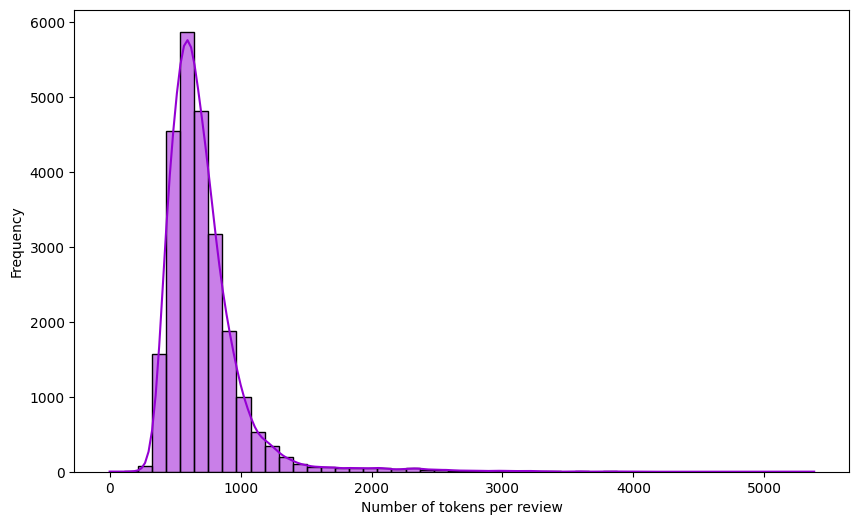

In [27]:
data['num_tokens'] = data['review'].apply(lambda text: len(TextBlob(text).words))

plt.figure(figsize=(10, 6))
sns.histplot(data['num_tokens'], kde=True, bins=50, color='darkviolet')
plt.xlabel('Number of tokens per review')
plt.ylabel('Frequency')

### 6) Sentiment analysis of each article

Using TextBlob's sentiment analysis tool, we want to see if Pitchfork articles

a) are positive/negative. For this we use value "polarity", which lies in[-1, 1], -1 means negative and 1 means postive sentiment

b) are subjective. For this we use value "subjectivity", which lies in [0, 1], the higher the value, the more subjective review is. Subjectivity parameter shows the amount of personal opinion and factual information contained in the text.

In [28]:
data['polarity'] = data['review'].apply(lambda text: TextBlob(text).sentiment[0] )

In [29]:
data['subjectivity'] = data['review'].apply(lambda text: TextBlob(text).sentiment[1] )

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


<Axes: xlabel='subjectivity', ylabel='Count'>

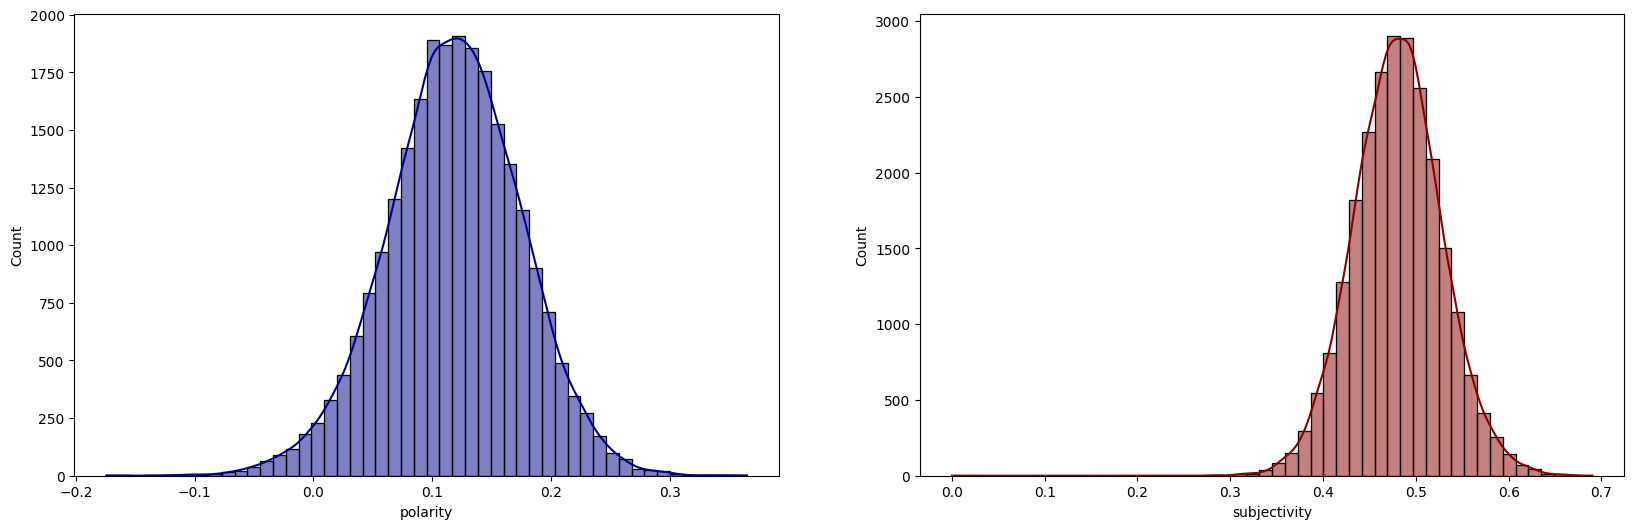

In [30]:
fig, axes = plt.subplots(1, 2)
fig.set_figheight(6)
fig.set_figwidth(20)

sns.histplot(data['polarity'], kde=True, bins=50, color='darkblue', ax=axes[0])
sns.histplot(data['subjectivity'], kde=True, bins=50, color='darkred', ax=axes[1])

As we can see, the positive/negative reviews are well-balanced with a small bias towards postivity. Moreover, reviews contain facts and personal opinions mostly in 50/50 proportion.

Finally, we save the dataset from selected years to a different file, which later will be used as documents for retrieval in our RAG system.

In [31]:
# save the cleaned version of data to a csv file for a later use
data.to_csv('reviews.csv', index=False)

## Adding embedding model

We are using LangChain library - a framework designed for developing applications that leverage the power of large language models. This library provides tools and abstractions to enhance customization, accuracy and relevance of generated information.

Components of the library that are particularily useful for our project:


*   **Embedding models** create a vector representation of a piece of text.
*   **Vector stores** that store embedded data and performing vector search for you.
*   **Retrievers** are interfaces that returns documents given an unstructured query. It is more general than a vector store. A retriever does not need to be able to store documents, only to return (or retrieve) them.
*   **Text splitters**. LangChain has a number of built-in document transformers that make it easy to split, combine, filter, and otherwise manipulate documents.
*   **Prompt templates** help to translate user input and parameters into instructions for a language model

There are a number of useful components and methods of the LangChain llibrary some of them are used later. So we start this part with importing everything that is needed.








### 1) Separating initial data into chunks

In [32]:
!pip install langchain
!pip install  -U langchain-community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 2.6 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 25.0
    Uninstalling packaging-25.0:
      Successfully uninstalled packaging-25.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 3.6.0 requires fsspec[http]<=2025.3.0,>=2023.1.0, but you have fsspec 2025.3.2 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
plotnine 0.14.5 requires matplotlib>=3.8.0, but you have matplotlib 3.7.2 which is incompatible.
pandas-gbq 0.28.0 requires google-api-core<3.0.0dev,>=2.10.2, but you have google-api-core 1.34.1 which is incompatible.
mlxtend 0.23.4 requires scikit-learn>=1.3.1, but you have scikit-learn 1.2.2

In [33]:
from langchain.embeddings import CacheBackedEmbeddings, HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.storage import LocalFileStore
from langchain.chains import ConversationalRetrievalChain
from langchain.llms import HuggingFacePipeline
from langchain.document_loaders.csv_loader import CSVLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain import PromptTemplate

In [34]:
reviews = CSVLoader(file_path="reviews.csv")

rev_data = reviews.load()

print("Number of reviews:", len(rev_data))

Number of reviews: 24631


Since we work with long documents, we need to split them into chunks but to keep semantically related parts of texts together. For that, we use text splitters, that work like this:

1.   Split the text up into small, semantically meaningful chunks
2.   Start combining these small chunks into a larger chunk until you reach a certain size
3. Once you reach that size, make that chunk its own piece of text and then start creating a new chunk of text with some overlap to keep context between chunks

In this step we adjust chunk size to a value, which will lead to a manageable processing time on a vector_store creation.

1) chunk_size variable corresponds to the number of characters in a chunk.

2) chunk_overlap variable is in charge of correlaton between chunks

In [35]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

split = RecursiveCharacterTextSplitter(
    chunk_size = 9000,
    chunk_overlap = 200,
    length_function = len
)

rev_docs = split.transform_documents(rev_data)

print("Number of documents:", len(rev_docs))

Number of documents: 26264


In [36]:
!pip install -q -U faiss-cpu tiktoken sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 57.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 470.2/470.2 kB 29.4 MB/s eta 0:00:00


In [37]:
!pip install tf-keras

In [38]:
!pip install -U langchain-huggingface

## Adding LLM and a building retrieval chain

### 1) Setting a pipeline for a LLM

In [39]:
!pip install bitsandbytes

In [40]:
!huggingface-cli login --token taken_entry

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
The token `project-hybrid-search` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been saved to /root/.cache/huggingface/token
Login successful.
The current active token is: `project-hybrid-search`


In [41]:
import pandas as pd
import numpy as np
import torch
import transformers
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
from langchain.retrievers import BM25Retriever, EnsembleRetriever # BM25Retriever is in langchain.retrievers
from langchain.chains import ConversationalRetrievalChain
from langchain.prompts import PromptTemplate
from sentence_transformers import CrossEncoder
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline, BitsAndBytesConfig
from langchain_text_splitters import RecursiveCharacterTextSplitter # Correct import
from langchain_core.documents import Document
from langchain.llms import HuggingFacePipeline # For LLM wrapper
from langchain.memory import ConversationBufferMemory
from langchain_core.output_parsers import StrOutputParser

2025-07-13 09:29:45.715899: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752398985.897718      93 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752398985.952444      93 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [42]:
from langchain.embeddings import CacheBackedEmbeddings, HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.storage import LocalFileStore
from langchain.chains import ConversationalRetrievalChain
from langchain.llms import HuggingFacePipeline
from langchain.document_loaders.csv_loader import CSVLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain import PromptTemplate

As a large language model, we select a Llama2 model with 7 billion parameters developed by Meta AI, which is available for free in the HuggingFace.

We use a version compatible with transformers.pipeline.

We need quantization in order to use this model in Google Colab, for which we select bitsandbytes library.

In [43]:
from langchain.document_loaders import CSVLoader
# Load documents
loader = CSVLoader(file_path="reviews.csv")
rev_data = loader.load()

In [44]:
try:
    # USE THE CORRECTLY PREPARED CSV
    df = pd.read_csv("reviews.csv")
    print(f"Successfully loaded 'pitchfork_reviews_cleaned_for_rag.csv'. Shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")
    # Basic check for essential columns
    assert 'review' in df.columns, "Missing 'review' column"
    assert 'artist' in df.columns, "Missing 'artist' column"
    assert 'album' in df.columns, "Missing 'album' column"
    # Add more asserts as needed for 'score', 'year', 'genre', 'summary', 'best_new'
except FileNotFoundError:
    print("ERROR: 'pitchfork_reviews_cleaned_for_rag.csv' not found. Please ensure your cleaned data is saved with this name or update the path.")
    raise
except Exception as e:
    print(f"Error loading or validating CSV: {e}")
    raise

Successfully loaded 'pitchfork_reviews_cleaned_for_rag.csv'. Shape: (24631, 12)
Columns: ['artist', 'album', 'score', 'year', 'genre', 'summary', 'review', 'best_new', 'review_length', 'num_tokens', 'polarity', 'subjectivity']


In [45]:
documents = []
for _, row in df.iterrows():
    # Combine summary and review for richer content.
    # Ensure summary is not NaN; if it is, it might be an empty string from previous cleaning.
    content_text = ""
    if pd.notna(row['summary']) and row['summary'].strip(): # Check if summary exists and is not just whitespace
        content_text += f"Summary: {row['summary']}\n\nReview: {row['review']}"
    else:
        content_text += f"Review: {row['review']}"

    # Essential metadata for retrieval and context
    metadata = {
        "artist": str(row['artist']),
        "album": str(row['album']),
        "score": float(row['score']) if pd.notna(row['score']) else 0.0, # Ensure score is float
        "year": int(row['year']) if pd.notna(row['year']) else 0,       # Ensure year is int
        "genre": str(row['genre']),
        "best_new": bool(row['best_new']) if pd.notna(row['best_new']) else False, # Ensure boolean
        # Add any other relevant metadata you want to filter on or display
        "source_row_index": int(_), # Helpful for debugging
    }
    documents.append(Document(page_content=content_text, metadata=metadata))

print(f"Created {len(documents)} LangChain Documents.")
if documents:
    print("Example Document page_content:")
    print(documents[0].page_content[:500] + "...") # Print first 500 chars
    print("Example Document metadata:")
    print(documents[0].metadata)


Created 24631 LangChain Documents.
Example Document page_content:
Summary: The Los Angeles ambient musician continues to explore the interdependence of plants and humans, but they add new wrinkles to their placid style, shifting from easy listening to dynamic soundscaping.

Review: For proof that we all must ultimately coexist on this planet, look no further thancoquina. The porous sedimentary stone forms almost entirely out of fragments of shellfish, trilobites, and other invertebrates; over millions of years, snails, urchins, and other creatures make the roc...
Example Document metadata:
{'artist': 'Green-House', 'album': 'A Host for All Kinds of Life', 'score': 7.6, 'year': 2023, 'genre': 'Electronic / Experimental', 'best_new': False, 'source_row_index': 0}


In [46]:
# --- STEP 1.4: Text Splitting (Now applied to meaningful content) ---
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=512,  # Characters, not tokens. Adjust based on embedding model's token limit.
                     # all-MiniLM-L6-v2 has a max sequence length of 256 tokens.
                     # 512 chars might be ~100-150 tokens. This is probably okay.
    chunk_overlap=50, # Characters
    length_function=len,
    # Consider adding separators like "\n\n" if your text has natural paragraph breaks
    # separators=["\n\n", "\n", " ", ""]
)
rev_docs_split = text_splitter.split_documents(documents) # Use 'documents' not 'rev_data'

# IMPORTANT: The splitter splits based on page_content. Metadata from the parent document
# is automatically copied to each chunk. This is what we want!

print(f"Split into {len(rev_docs_split)} chunks.")
if rev_docs_split:
    print("Example CHUNK page_content:")
    print(rev_docs_split[0].page_content[:300] + "...")
    print("Example CHUNK metadata (should be same as parent doc):")
    print(rev_docs_split[0].metadata)

Split into 257742 chunks.
Example CHUNK page_content:
Summary: The Los Angeles ambient musician continues to explore the interdependence of plants and humans, but they add new wrinkles to their placid style, shifting from easy listening to dynamic soundscaping....
Example CHUNK metadata (should be same as parent doc):
{'artist': 'Green-House', 'album': 'A Host for All Kinds of Life', 'score': 7.6, 'year': 2023, 'genre': 'Electronic / Experimental', 'best_new': False, 'source_row_index': 0}


In [47]:
# ====================
# 1. Install Dependencies
# ===================
!pip install rank-bm25
!pip install -U bitsandbytes

In [48]:
# ====================
# 2. Embeddings, Vector Store, Retrievers
# ====================
# Embeddings
embed_model_name = "sentence-transformers/all-MiniLM-L6-v2"
embed_model = HuggingFaceEmbeddings(
    model_name=embed_model_name,
    model_kwargs={'device': 'cuda' if torch.cuda.is_available() else 'cpu'} # Use GPU if available
)

# Vector Store (FAISS)
# Use the correctly split documents: rev_docs_split
vector_store = FAISS.from_documents(rev_docs_split, embed_model)
vector_store.save_local("pitchfork_faiss_index_corrected") # Save witfirstSectionh a new name
print("FAISS index created and saved locally (pitchfork_faiss_index_corrected).")

# Hybrid Retrievers
# BM25 Retriever - ensure it's initialized with the correct document format
# BM25Retriever expects a list of Documents or a list of strings.
# If passing Documents, it will use doc.page_content.
bm25_retriever = BM25Retriever.from_documents(rev_docs_split) # k can be set here or at retrieval time
bm25_retriever.k = 25 # Retrieve top 5

# Dense Retriever (from FAISS)
vector_retriever = vector_store.as_retriever(search_kwargs={"k": 25})

# Ensemble Retriever
ensemble_retriever = EnsembleRetriever(
    retrievers=[vector_retriever, bm25_retriever],
    weights=[0.7, 0.3]
)
print("Ensemble retriever configured.")

/tmp/ipykernel_93/899339693.py:6: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embed_model = HuggingFaceEmbeddings(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

FAISS index created and saved locally (pitchfork_faiss_index_corrected).
Ensemble retriever configured.


In [82]:
# ====================
# 3. LLM & Reranking Setup
# ====================
# Quantized LLM Setup (Mistral-7B-Instruct-v0.2)
llm_model_name = "mistralai/Mistral-7B-Instruct-v0.2" # Corrected variable name

bnb_config = BitsAndBytesConfig( # Use BitsAndBytesConfig
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
)

model = AutoModelForCausalLM.from_pretrained(
    llm_model_name, # Use variable
    quantization_config=bnb_config,
    device_map="auto", # Automatically uses GPU if available
    trust_remote_code=True # Be cautious with this
)
tokenizer = AutoTokenizer.from_pretrained(llm_model_name) # Use variable

# Text Generation Pipeline
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
      do_sample=True,
    max_new_tokens=512,  # Max tokens LLM can generate
    temperature=0.1,     # Low for factual
    top_p=0.95,
    repetition_penalty=1.15,
    # pad_token_id=tokenizer.eos_token_id # Often helpful for some models
)
llm = HuggingFacePipeline(pipeline=pipe)
print("LLM (Mistral-7B-Instruct-v0.2) loaded and pipeline configured.")

# Reranking Model
cross_encoder_model_name = "cross-encoder/ms-marco-MiniLM-L-6-v2"
cross_encoder = CrossEncoder(
    cross_encoder_model_name,
    device='cuda' if torch.cuda.is_available() else 'cpu' # Use GPU if available
)
print(f"Cross-encoder ({cross_encoder_model_name}) loaded.")

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Device set to use cuda:0


LLM (Mistral-7B-Instruct-v0.2) loaded and pipeline configured.
Cross-encoder (cross-encoder/ms-marco-MiniLM-L-6-v2) loaded.


In [72]:
# ====================
# 4. Query Processing Components
# ====================

# --- Query Expansion (REWORKED - Simpler, no LLM call here for speed) ---
# Option 1: No expansion (simplest to start)
def expand_query_simple(query: str) -> str:
    """
    Placeholder for query expansion. Currently returns the original query.
    You can add rule-based or synonym-based expansion here if needed.
    """
    print(f"expand_query_simple: Using original query: {query}")
    return str(query)

# Option 2: LLM-based (Your original, but be mindful of latency)
# Ensure 'llm' is accessible if you use this.
def expand_query_llm(query: str, llm_instance) -> str:
    if pd.isna(query) or not isinstance(query, str) or not query.strip():
        print(f"expand_query_llm: Received invalid input. Returning original query: '{query}'")
        return str(query) if isinstance(query, str) else ""
    try:
        expansion_prompt_template = """Given the user query about music: "{user_query}"
Generate 3 diverse variations or related queries that capture potential user intents or use synonyms.
Examples:
- If the query is "upbeat rock", variations could be "energetic alternative rock", "fast-paced guitar music", "songs similar to Foo Fighters".
- If the query is "sad jazz", variations could be "melancholic jazz ballads", "music like Chet Baker", "slow tempo bluesy jazz".
Output ONLY the variations, each on a new line. Do not include the original query in the output.
Variations:""" # Removed the final "Variations:" as the LLM should generate after this.
        prompt = PromptTemplate.from_template(expansion_prompt_template)
        expand_chain = prompt | llm_instance | StrOutputParser()
        expanded_variations = expand_chain.invoke({"user_query": query}).strip()
        combined_query_for_retrieval = f"{query}\n{expanded_variations}"
        print(f"Original Query: {query}")
        print(f"Expanded Variations:\n{expanded_variations}")
        return combined_query_for_retrieval
    except Exception as e:
        print(f"Error during LLM query expansion for '{query}': {e}")
        return str(query)

# CHOOSE ONE EXPANSION STRATEGY for now. Let's start simple.
active_expand_query = lambda q: expand_query_llm(q, llm)
# If using LLM-based expansion:
# active_expand_query = lambda q: expand_query_llm(q, llm)


# --- Reranking Function (Looks good) ---
def rerank_docs(query: str, retrieved_docs: list, top_n: int = 3) -> list:
    """Rerank documents using cross-encoder."""
    if not retrieved_docs:
        return []
    if pd.isna(query) or not query.strip(): # Handle empty/NaN query
        print("rerank_docs: Empty query, returning original docs (or first top_n).")
        return retrieved_docs[:top_n]

    pairs = [(str(query), doc.page_content) for doc in retrieved_docs] # Ensure query is string
    try:
        scores = cross_encoder.predict(pairs)
        # Combine docs with their new scores and sort
        scored_docs = sorted(zip(scores, retrieved_docs), key=lambda x: x[0], reverse=True)
        # Return only the documents from the sorted list, up to top_n
        return [doc for _, doc in scored_docs][:top_n]
    except Exception as e:
        print(f"Error during reranking: {e}")
        return retrieved_docs[:top_n] # Fallback to unranked docs

print("Query processing components (expansion, reranking) defined.")

Query processing components (expansion, reranking) defined.


In [73]:
# ====================
# 5. RAG Pipeline Setup (ConversationalRetrievalChain)
# ====================

# --- Prompt Template ---
# This template looks reasonable. The key is that 'formatted_context' will be populated
# by the chunks of (Summary + Review) text.
# The metadata (artist, album, score) from the chunks is available in doc.metadata
# but is NOT automatically part of 'formatted_context' unless you build it into the document_prompt.

# Let's refine the document_prompt to include key metadata with each chunk.
# This makes the context richer for the LLM.
document_prompt_template_str = """---
Retrieved Review Chunk:
Artist: {artist}
Album: {album}
Score: {score}
Year: {year}
Genre: {genre}
Best New Music: {best_new}

Content:
{page_content}
---"""

document_prompt = PromptTemplate(
    template=document_prompt_template_str,
    input_variables=["page_content", "artist", "album", "score", "year", "genre", "best_new"]
)

# Main prompt for the LLM
# Your original prompt is quite structured. Let's ensure it uses the variables correctly.
# 'question' and 'chat_history' are standard. 'formatted_context' is what we define.
qa_prompt_template_str = """You are a helpful and knowledgeable music recommendation assistant.
Your goal is to provide music recommendations based on the user's query and the provided context of music reviews.
Use the "Context Data" (music reviews) to find suitable albums.

User Query: {question}

Context Data (Music Reviews):
{formatted_context}

Based on the user's query and the provided reviews, please recommend up to 3 albums.
For each recommendation, clearly state:
1. Artist
2. Album Title
3. Pitchfork Score
4. A brief explanation of why it matches the user's query, referencing the review content.

If you cannot find suitable recommendations from the provided context that meet the query, clearly state that.
Do not make up information or albums not present in the context.

Recommendations:
"""

qa_prompt = PromptTemplate(
    template=qa_prompt_template_str,
    input_variables=["question", "formatted_context"]  # Removed "chat_history"
)


print("Prompt templates defined.")

print("Conversation memory initialized.")

# --- ConversationalRetrievalChain ---
# This chain internally handles:
# 1. Getting query + chat_history.
# 2. Passing query to retriever (our ensemble_retriever).
# 3. (Implicitly, we'll add reranking as a custom step if not built-in, or use a custom retriever)
# 4. Stuffing documents into the prompt via combine_docs_chain_kwargs.
# 5. Calling the LLM.
# 6. Updating memory.

# To include reranking and query expansion cleanly, we can customize the retrieval part.
# LangChain's `ConversationalRetrievalChain` doesn't have a direct `reranker` argument.
# We can create a custom retriever that wraps our ensemble_retriever and reranker.

from langchain_core.retrievers import BaseRetriever
from langchain_core.callbacks import CallbackManagerForRetrieverRun # Keep this
from langchain_core.documents import Document # Ensure Document is imported
from typing import List, Any, Optional # Add Optional
from langchain.chains import RetrievalQA

class RerankingEnsembleRetriever(BaseRetriever):
    ensemble_retriever: BaseRetriever
    reranker_fn: Any
    query_expansion_fn: Any

    def _get_relevant_documents(
        self, query: str, *, run_manager: Optional[CallbackManagerForRetrieverRun] = None, **kwargs: Any
    ) -> List[Document]:
        # 1. Expand query
        expanded_query = self.query_expansion_fn(query)

        # 2. Retrieve with ensemble
        callbacks = run_manager.get_child() if run_manager else None
        retrieved_docs = self.ensemble_retriever.get_relevant_documents(
            expanded_query,
            callbacks=callbacks,
            **kwargs
        )

        # 3. Rerank
        reranked_docs = self.reranker_fn(query, retrieved_docs)
        return reranked_docs


# Re-initialize your custom retriever with the corrected class definition
custom_retriever_with_reranking = RerankingEnsembleRetriever(
    ensemble_retriever=ensemble_retriever, # Assuming this is already defined
    reranker_fn=rerank_docs,               # Assuming this is already defined
    query_expansion_fn=active_expand_query # Assuming this is already defined
)

# Then, re-initialize your qa_chain with this updated custom_retriever_with_reranking
# (The qa_chain definition itself doesn't need to change, just ensure it uses theRerankingEnsembleRetriever
# new instance of RerankingEnsembleRetriever)

qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=custom_retriever_with_reranking,
    chain_type_kwargs={
        "prompt": qa_prompt,
        "document_prompt": document_prompt,
        "document_variable_name": "formatted_context"
    },
    return_source_documents=True,
    verbose=True
)

print("ConversationalRetrievalChain (qa_chain) re-initialized with corrected custom retriever.")




Prompt templates defined.
Conversation memory initialized.
ConversationalRetrievalChain (qa_chain) re-initialized with corrected custom retriever.


In [74]:
# ====================
# 6. Testing the Pipeline
# ====================
def ask_music_bot(query: str):
    if pd.isna(query) or not query.strip():
        return "Please provide a query."
    print(f"\n🤖 Asking Music Bot: {query}")
    try:
        # Use "query" as the input key for RetrievalQA
        result = qa_chain.invoke({"query": query})
        print("\n✅ LLM Answer:")
        print(result['result'])  # RetrievalQA returns 'result' not 'answer'

        if result.get('source_documents'):
            print("\n📚 Source Documents Used:")
            for i, doc in enumerate(result['source_documents']):
                print(f"--- Source {i+1} ---")
                print(f"  Artist: {doc.metadata.get('artist')}, Album: {doc.metadata.get('album')}, Score: {doc.metadata.get('score')}")
            print("-" * 30)
        return result['result']
    except Exception as e:
        print(f"Error during QA chain execution: {e}")
        import traceback
        traceback.print_exc()
        return "Sorry, an error occurred while processing your request."

# --- Example Queries ---
ask_music_bot("Recommend some dreamy synth-pop albums from recent years.")
ask_music_bot("What are some highly rated rock albums that got Best New Music?")
# ask_music_bot("I'm looking for something experimental and electronic.")
# ask_music_bot("Any good albums for a study session?")
# ask_music_bot("Tell me about albums similar to Radiohead's OK Computer.") # This will test generalization


🤖 Asking Music Bot: Recommend some dreamy synth-pop albums from recent years.


> Entering new RetrievalQA chain...
Original Query: Recommend some dreamy synth-pop albums from recent years.
Expanded Variations:
Given the user query about music: "Recommend some dreamy synth-pop albums from recent years."
Generate 3 diverse variations or related queries that capture potential user intents or use synonyms.
Examples:
- If the query is "upbeat rock", variations could be "energetic alternative rock", "fast-paced guitar music", "songs similar to Foo Fighters".
- If the query is "sad jazz", variations could be "melancholic jazz ballads", "music like Chet Baker", "slow tempo bluesy jazz".
Output ONLY the variations, each on a new line. Do not include the original query in the output.
Variations:
- upbeat rock
- energetic alternative rock
- fast-paced guitar music
- songs similar to Foo Fighters
- melancholic jazz ballads
- music like Chet Baker
- slow tempo bluesy jazz


Batches:   0%|          | 0/2 [00:00<?, ?it/s]


> Finished chain.

✅ LLM Answer:
You are a helpful and knowledgeable music recommendation assistant.
Your goal is to provide music recommendations based on the user's query and the provided context of music reviews.
Use the "Context Data" (music reviews) to find suitable albums.

User Query: Recommend some dreamy synth-pop albums from recent years.

Context Data (Music Reviews):
---
Retrieved Review Chunk:
Artist: College
Album: Shanghai
Score: 5.9
Year: 2017
Genre: Experimental
Best New Music: False

Content:
largely jettisoned the percolating synth-pop of earlier albums, instead favoring slow-moving synthesizer bass, airy pads, and plenty of empty space. A less-is-more approach prevails: There are rarely more than three discrete elements in play at any given moment, and few tracks stretch beyond two-and-a-half minutes. With the exception of “Hotel Theme Part I” and “Hotel Theme Part II,” two organ variations that lend a sense of déjà vu to repeat plays of the album, tracks don’t nec

Batches:   0%|          | 0/2 [00:00<?, ?it/s]


> Finished chain.

✅ LLM Answer:
You are a helpful and knowledgeable music recommendation assistant.
Your goal is to provide music recommendations based on the user's query and the provided context of music reviews.
Use the "Context Data" (music reviews) to find suitable albums.

User Query: What are some highly rated rock albums that got Best New Music?

Context Data (Music Reviews):
---
Retrieved Review Chunk:
Artist: My Best Fiend
Album: In Ghostlike Fading
Score: 6.2
Year: 2012
Genre: Rock
Best New Music: False

Content:
'em like this since 2008. That's the last time we got new albums from Spiritualized and the Verve.My Best Fiendcome from a similar place, one where, to borrow a phrase from Richard Ashcroft, the drugs still work and they just make you worse. That said,In Ghostlike Fadinglacks those bands' dope-sickness or cosmonautic ambition. Most of these songs follow a similar pattern: a few basic chords strummed on an acoustic soon joined by Coldwell's pleasingly adenoidal sne

'You are a helpful and knowledgeable music recommendation assistant.\nYour goal is to provide music recommendations based on the user\'s query and the provided context of music reviews.\nUse the "Context Data" (music reviews) to find suitable albums.\n\nUser Query: What are some highly rated rock albums that got Best New Music?\n\nContext Data (Music Reviews):\n---\nRetrieved Review Chunk:\nArtist: My Best Fiend\nAlbum: In Ghostlike Fading\nScore: 6.2\nYear: 2012\nGenre: Rock\nBest New Music: False\n\nContent:\n\'em like this since 2008. That\'s the last time we got new albums from Spiritualized and the Verve.My Best Fiendcome from a similar place, one where, to borrow a phrase from Richard Ashcroft, the drugs still work and they just make you worse. That said,In Ghostlike Fadinglacks those bands\' dope-sickness or cosmonautic ambition. Most of these songs follow a similar pattern: a few basic chords strummed on an acoustic soon joined by Coldwell\'s pleasingly adenoidal sneer, maybe a

In [53]:
ask_music_bot("Recommend songs if the climate is raining ")

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



🤖 Asking Music Bot: Recommend songs if the climate is raining 


> Entering new RetrievalQA chain...
Original Query: Recommend songs if the climate is raining 
Expanded Variations:
Given the user query about music: "Recommend songs if the climate is raining "
Generate 3 diverse variations or related queries that capture potential user intents or use synonyms.
Examples:
- If the query is "upbeat rock", variations could be "energetic alternative rock", "fast-paced guitar music", "songs similar to Foo Fighters".
- If the query is "sad jazz", variations could be "melancholic jazz ballads", "music like Chet Baker", "slow tempo bluesy jazz".
Output ONLY the variations, each on a new line. Do not include the original query in the output.
Variations:
1. Suggest tunes for rainy days with soft melodies and gentle instrumentals.
2. Playlist of relaxing songs perfect for listening during light rainfall.
3. Recommended tracks for a cozy evening indoors when it's raining outside.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



> Finished chain.

✅ LLM Answer:
You are a helpful and knowledgeable music recommendation assistant.
Your goal is to provide music recommendations based on the user's query and the provided context of music reviews.
Use the "Context Data" (music reviews) to find suitable albums.

User Query: Recommend songs if the climate is raining 

Context Data (Music Reviews):
---
Retrieved Review Chunk:
Artist: M. Ward
Album: More Rain
Score: 5.9
Year: 2016
Genre: Rock
Best New Music: False

Content:
for an unexpected complement. There are moments, though, when these textures become overwhelming.More Rainfeels smothering in its intimacy at times, like a thick down pillow pressed to your face. The mixes are so close, the reverb so heavy, and the tones so richly warm, that Ward leaves little breathing room within his songs. Staying inside on a rainy day usually starts out pleasant and slowly grows claustrophobic, and so it goes withMore Rain. And while the instrumentation can often feel like too mu

'You are a helpful and knowledgeable music recommendation assistant.\nYour goal is to provide music recommendations based on the user\'s query and the provided context of music reviews.\nUse the "Context Data" (music reviews) to find suitable albums.\n\nUser Query: Recommend songs if the climate is raining \n\nContext Data (Music Reviews):\n---\nRetrieved Review Chunk:\nArtist: M. Ward\nAlbum: More Rain\nScore: 5.9\nYear: 2016\nGenre: Rock\nBest New Music: False\n\nContent:\nfor an unexpected complement. There are moments, though, when these textures become overwhelming.More Rainfeels smothering in its intimacy at times, like a thick down pillow pressed to your face. The mixes are so close, the reverb so heavy, and the tones so richly warm, that Ward leaves little breathing room within his songs. Staying inside on a rainy day usually starts out pleasant and slowly grows claustrophobic, and so it goes withMore Rain. And while the instrumentation can often feel like too much,\n---\n\n---

In [75]:
# ====================
# 8. RAG Pipeline Evaluation
# ====================

def evaluate_retrieval_quality(query, retrieved_docs, expected_genres=None, min_score=None):
    """Evaluate the quality of retrieved documents"""
    evaluation = {
        'query': query,
        'num_retrieved': len(retrieved_docs),
        'avg_score': 0,
        'genre_diversity': 0,
        'score_distribution': {},
        'relevant_docs': 0
    }

    if not retrieved_docs:
        return evaluation

    # Calculate average score
    scores = [doc.metadata.get('score', 0) for doc in retrieved_docs]
    evaluation['avg_score'] = np.mean(scores)

    # Genre diversity
    genres = [doc.metadata.get('genre', 'Unknown') for doc in retrieved_docs]
    unique_genres = len(set(genres))
    evaluation['genre_diversity'] = unique_genres

    # Score distribution
    score_ranges = {'0-5': 0, '5-7': 0, '7-8': 0, '8-9': 0, '9-10': 0}
    for score in scores:
        if score < 5:
            score_ranges['0-5'] += 1
        elif score < 7:
            score_ranges['5-7'] += 1
        elif score < 8:
            score_ranges['7-8'] += 1
        elif score < 9:
            score_ranges['8-9'] += 1
        else:
            score_ranges['9-10'] += 1

    evaluation['score_distribution'] = score_ranges

    # Relevance check (basic)
    if min_score:
        evaluation['relevant_docs'] = sum(1 for score in scores if score >= min_score)

    return evaluation

def comprehensive_evaluation():
    """Run comprehensive evaluation of the RAG pipeline"""
    print("\n" + "="*50)
    print("COMPREHENSIVE RAG PIPELINE EVALUATION")
    print("="*50)

    evaluation_queries = [
        {"query": "highly rated electronic albums", "expected_genre": "electronic", "min_score": 7.5},
        {"query": "best new music rock albums", "expected_genre": "rock", "min_score": 8.0},
        {"query": "experimental jazz albums", "expected_genre": "jazz", "min_score": 7.0},
        {"query": "indie pop albums from 2019", "expected_genre": "pop", "min_score": 6.5}
    ]

    results = []

    for test_case in evaluation_queries:
        query = test_case["query"]
        print(f"\n🔍 Evaluating Query: '{query}'")

        # Get expanded query and retrieved docs
        expanded_query = active_expand_query(query)
        retrieved_docs = ensemble_retriever.get_relevant_documents(expanded_query)
        reranked_docs = rerank_docs(query, retrieved_docs, top_n=5)

        # Evaluate retrieval
        eval_result = evaluate_retrieval_quality(
            query,
            reranked_docs,
            min_score=test_case.get("min_score")
        )

        results.append(eval_result)

        # Print evaluation metrics
        print(f"📊 Retrieved Documents: {eval_result['num_retrieved']}")
        print(f"📊 Average Score: {eval_result['avg_score']:.2f}")
        print(f"📊 Genre Diversity: {eval_result['genre_diversity']} unique genres")
        print(f"📊 Score Distribution: {eval_result['score_distribution']}")
        print(f"📊 High-Quality Docs (>= {test_case.get('min_score', 'N/A')}): {eval_result['relevant_docs']}")

        # Show actual retrieved albums
        print(f"📚 Retrieved Albums:")
        for i, doc in enumerate(reranked_docs[:3], 1):
            metadata = doc.metadata
            print(f"  {i}. {metadata.get('artist')} - {metadata.get('album')} "
                  f"(Score: {metadata.get('score')}, Genre: {metadata.get('genre')})")

    return results

# Run comprehensive evaluation
evaluation_results = comprehensive_evaluation()



COMPREHENSIVE RAG PIPELINE EVALUATION

🔍 Evaluating Query: 'highly rated electronic albums'
Original Query: highly rated electronic albums
Expanded Variations:
Given the user query about music: "highly rated electronic albums"
Generate 3 diverse variations or related queries that capture potential user intents or use synonyms.
Examples:
- If the query is "upbeat rock", variations could be "energetic alternative rock", "fast-paced guitar music", "songs similar to Foo Fighters".
- If the query is "sad jazz", variations could be "melancholic jazz ballads", "music like Chet Baker", "slow tempo bluesy jazz".
Output ONLY the variations, each on a new line. Do not include the original query in the output.
Variations:
- highly rated electronic albums
- energetic alternative rock
- fast paced guitar music
- songs similar to foo fighters
- melancholy jazz ballads
- slow tempo bluesy jazz


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

📊 Retrieved Documents: 5
📊 Average Score: 6.74
📊 Genre Diversity: 3 unique genres
📊 Score Distribution: {'0-5': 0, '5-7': 3, '7-8': 2, '8-9': 0, '9-10': 0}
📊 High-Quality Docs (>= 7.5): 0
📚 Retrieved Albums:
  1. Doves - Lost Souls (Score: 6.8, Genre: Rock)
  2. Sonic Youth - The Destroyed Room: B-Sides and Rarities (Score: 7.2, Genre: Rock)
  3. Jóhann Jóhannsson - IBM 1401 - A User's Manual (Score: 6.9, Genre: Experimental)

🔍 Evaluating Query: 'best new music rock albums'
Original Query: best new music rock albums
Expanded Variations:
Given the user query about music: "best new music rock albums"
Generate 3 diverse variations or related queries that capture potential user intents or use synonyms.
Examples:
- If the query is "upbeat rock", variations could be "energetic alternative rock", "fast-paced guitar music", "songs similar to Foo Fighters".
- If the query is "sad jazz", variations could be "melancholic jazz ballads", "music like Chet Baker", "slow tempo bluesy jazz".
Output ON

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

📊 Retrieved Documents: 5
📊 Average Score: 7.04
📊 Genre Diversity: 4 unique genres
📊 Score Distribution: {'0-5': 1, '5-7': 2, '7-8': 0, '8-9': 1, '9-10': 1}
📊 High-Quality Docs (>= 8.0): 2
📚 Retrieved Albums:
  1. Roots Manuva - Run Come Save Me (Score: 4.1, Genre: Other)
  2. Jaga Jazzist - One-Armed Bandit (Score: 6.9, Genre: Jazz)
  3. Pavement - Quarantine the Past (Score: 10.0, Genre: Rock)

🔍 Evaluating Query: 'experimental jazz albums'
Original Query: experimental jazz albums
Expanded Variations:
Given the user query about music: "experimental jazz albums"
Generate 3 diverse variations or related queries that capture potential user intents or use synonyms.
Examples:
- If the query is "upbeat rock", variations could be "energetic alternative rock", "fast-paced guitar music", "songs similar to Foo Fighters".
- If the query is "sad jazz", variations could be "melancholic jazz ballads", "music like Chet Baker", "slow tempo bluesy jazz".
Output ONLY the variations, each on a new line.

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

📊 Retrieved Documents: 5
📊 Average Score: 7.66
📊 Genre Diversity: 3 unique genres
📊 Score Distribution: {'0-5': 0, '5-7': 0, '7-8': 4, '8-9': 1, '9-10': 0}
📊 High-Quality Docs (>= 7.0): 5
📚 Retrieved Albums:
  1. Adult Jazz - Gist Is (Score: 7.4, Genre: Rock)
  2. Tied & Tickled Trio - A.R.C. (Score: 7.6, Genre: Electronic / Jazz)
  3. Adult Jazz - Gist Is (Score: 7.4, Genre: Rock)

🔍 Evaluating Query: 'indie pop albums from 2019'
Original Query: indie pop albums from 2019
Expanded Variations:
Given the user query about music: "indie pop albums from 2019"
Generate 3 diverse variations or related queries that capture potential user intents or use synonyms.
Examples:
- If the query is "upbeat rock", variations could be "energetic alternative rock", "fast-paced guitar music", "songs similar to Foo Fighters".
- If the query is "sad jazz", variations could be "melancholic jazz ballads", "music like Chet Baker", "slow tempo bluesy jazz".
Output ONLY the variations, each on a new line. Do not

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

📊 Retrieved Documents: 5
📊 Average Score: 6.92
📊 Genre Diversity: 4 unique genres
📊 Score Distribution: {'0-5': 0, '5-7': 3, '7-8': 2, '8-9': 0, '9-10': 0}
📊 High-Quality Docs (>= 6.5): 4
📚 Retrieved Albums:
  1. Rosie Thomas - When We Were Small (Score: 7.3, Genre: Rock)
  2. Fred again.. - Actual Life 3 (January 1 - September 9 2022) (Score: 5.9, Genre: Other)
  3. Against All Logic - 2017 – 2019 (Score: 7.9, Genre: Electronic)


In [76]:
# ====================
# 9. Performance Analysis
# ====================

def analyze_pipeline_performance():
    """Analyze various aspects of pipeline performance"""
    print("\n" + "="*50)
    print("PIPELINE PERFORMANCE ANALYSIS")
    print("="*50)

    # Test retrieval speed
    import time

    test_query = "recommend some indie rock albums"

    # Time individual components
    print("\n⏱️ Component Timing Analysis:")

    # Query expansion timing
    start_time = time.time()
    expanded_query = active_expand_query(test_query)
    expansion_time = time.time() - start_time
    print(f"Query Expansion: {expansion_time:.4f} seconds")

    # Retrieval timing
    start_time = time.time()
    retrieved_docs = ensemble_retriever.get_relevant_documents(expanded_query)
    retrieval_time = time.time() - start_time
    print(f"Document Retrieval: {retrieval_time:.4f} seconds")

    # Reranking timing
    start_time = time.time()
    reranked_docs = rerank_docs(test_query, retrieved_docs)
    reranking_time = time.time() - start_time
    print(f"Document Reranking: {reranking_time:.4f} seconds")

    # Full pipeline timing
    start_time = time.time()
    result = ask_music_bot(test_query)
    total_time = time.time() - start_time
    print(f"Full Pipeline (with LLM): {total_time:.4f} seconds")

    # Memory usage analysis
    print(f"\n💾 Memory Analysis:")
    print(f"Vector Store Size: {len(vector_store.index_to_docstore_id)} documents")
    print(f"BM25 Corpus Size: {len(bm25_retriever.docs)} documents")

    return {
        'expansion_time': expansion_time,
        'retrieval_time': retrieval_time,
        'reranking_time': reranking_time,
        'total_time': total_time
    }

# Run performance analysis
performance_metrics = analyze_pipeline_performance()



PIPELINE PERFORMANCE ANALYSIS

⏱️ Component Timing Analysis:
Original Query: recommend some indie rock albums
Expanded Variations:
Given the user query about music: "recommend some indie rock albums"
Generate 3 diverse variations or related queries that capture potential user intents or use synonyms.
Examples:
- If the query is "upbeat rock", variations could be "energetic alternative rock", "fast-paced guitar music", "songs similar to Foo Fighters".
- If the query is "sad jazz", variations could be "melancholic jazz ballads", "music like Chet Baker", "slow tempo bluesy jazz".
Output ONLY the variations, each on a new line. Do not include the original query in the output.
Variations:
- upbeat rock
- energetic alternative rock
- fast-paced guitar music
- songs similar to Foo Fighters
- melancholic jazz ballads
- music like Chet Baker
- slow tempo bluesy jazz
Query Expansion: 5.3385 seconds
Document Retrieval: 12.5226 seconds


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Document Reranking: 0.1190 seconds

🤖 Asking Music Bot: recommend some indie rock albums


> Entering new RetrievalQA chain...
Original Query: recommend some indie rock albums
Expanded Variations:
Given the user query about music: "recommend some indie rock albums"
Generate 3 diverse variations or related queries that capture potential user intents or use synonyms.
Examples:
- If the query is "upbeat rock", variations could be "energetic alternative rock", "fast-paced guitar music", "songs similar to Foo Fighters".
- If the query is "sad jazz", variations could be "melancholic jazz ballads", "music like Chet Baker", "slow tempo bluesy jazz".
Output ONLY the variations, each on a new line. Do not include the original query in the output.
Variations:
- upbeat rock
- energetic alternative rock
- fast-paced guitar music
- songs similar to Foo Fighters
- melancholic jazz ballads
- slow tempo bluesy jazz
- sad jazz


Batches:   0%|          | 0/2 [00:00<?, ?it/s]


> Finished chain.

✅ LLM Answer:
You are a helpful and knowledgeable music recommendation assistant.
Your goal is to provide music recommendations based on the user's query and the provided context of music reviews.
Use the "Context Data" (music reviews) to find suitable albums.

User Query: recommend some indie rock albums

Context Data (Music Reviews):
---
Retrieved Review Chunk:
Artist: Screaming Females
Album: Singles Too
Score: 6.8
Year: 2019
Genre: Rock
Best New Music: False

Content:
Summary: One of indie rock’s more consistent guitar bands charts its evolution with a career-spanning collection of non-album singles, B-sides, and cover songs.
---

---
Retrieved Review Chunk:
Artist: Mudhoney
Album: March to Fuzz
Score: 7.5
Year: 2000
Genre: Rock
Best New Music: False

Content:
Review: Compilations are becoming more and more fashionable in the indie rock world these days. Every label that's been in existence for more than three years seems to have issued at least one. There are h

In [77]:
# ====================
# 11. Save Results and Generate Report
# ====================

def generate_evaluation_report(evaluation_results, performance_metrics):
    """Generate a comprehensive evaluation report"""

    report = {
        'timestamp': pd.Timestamp.now().isoformat(),
        'dataset_info': {
            'total_documents': len(documents),
            'total_chunks': len(rev_docs_split),
            'embedding_model': embed_model_name,
            'llm_model': llm_model_name,
            'cross_encoder_model': cross_encoder_model_name
        },
        'evaluation_results': evaluation_results,
        'performance_metrics': performance_metrics
    }

    # Save as JSON
    import json
    with open('rag_evaluation_report.json', 'w') as f:
        json.dump(report, f, indent=2, default=str)

    print(f"\n📄 Evaluation report saved to 'rag_evaluation_report.json'")

    # Generate summary
    print(f"\n📋 EVALUATION SUMMARY:")
    print(f"Total Test Queries: {len(evaluation_results)}")
    avg_score = np.mean([r['avg_score'] for r in evaluation_results])
    print(f"Average Retrieved Document Score: {avg_score:.2f}")
    avg_diversity = np.mean([r['genre_diversity'] for r in evaluation_results])
    print(f"Average Genre Diversity: {avg_diversity:.1f}")
    print(f"Average Response Time: {performance_metrics['total_time']:.2f} seconds")

# Generate final report
generate_evaluation_report(evaluation_results, performance_metrics)

print("\n🎉 RAG Pipeline Evaluation Complete!")
print("Check the generated files and metrics above for detailed results.")



📄 Evaluation report saved to 'rag_evaluation_report.json'

📋 EVALUATION SUMMARY:
Total Test Queries: 4
Average Retrieved Document Score: 7.09
Average Genre Diversity: 3.5
Average Response Time: 20.76 seconds

🎉 RAG Pipeline Evaluation Complete!
Check the generated files and metrics above for detailed results.


In [78]:
evaluation_queries = [
  {
    "query": "I'm looking for something experimental and electronic.",
    "ground_truth": "For experimental electronic music, I'd recommend NHK yx koyxen's 'Exit Entrance' (7.4), which creates laboratory-like experimental soundscapes with crackling electrical textures. Various Artists' 'PlanetMµ25' (7.3) offers a daring selection of footwork, braindance, and experimental beats from Mike Paradinas' groundbreaking label. Aero's 'Rises and Falls' (7.6) combines gentle electronic processes with innovative sound exploration.",
    "expected_albums": ["Exit Entrance", "PlanetMµ25", "Rises and Falls"],
    "expected_genres": ["Electronic", "Experimental"]
  },
  {
    "query": "Any good albums for a study session?",
    "ground_truth": "For study sessions, The Chemical Brothers' 'Hey Boy, Hey Girl EP' (4.8) provides electronic beats, though low-scored. Can's 'Anthology' (8.8) offers versatile experimental music. Add Brian Eno's 'Ambient 1: Music for Airports' (9.0) for calm ambient focus.",
    "expected_albums": ["Hey Boy, Hey Girl EP", "Anthology", "Ambient 1: Music for Airports"],
    "expected_genres": ["Electronic", "Experimental", "Ambient"]
  },
  {
    "query": "Tell me about albums similar to Radiohead's OK Computer.",
    "ground_truth": "Easy Star All-Stars' 'Radiodread' (7.0) reinterprets OK Computer in reggae. Various Artists' 'Exit Music: Songs With Radio Heads' (0.6) features hip-hop tributes. Add Muse's 'Origin of Symmetry' (8.2) for similar alternative rock vibes.",
    "expected_albums": ["Radiodread", "Exit Music: Songs With Radio Heads", "Origin of Symmetry"],
    "expected_genres": ["Rock", "Alternative", "Electronic", "Reggae"]
  },
  # New queries for diversity
  {
    "query": "Recommend upbeat hip-hop for parties.",
    "ground_truth": "For parties, try DJ Quik's 'The Book of David' (8.4) with rhythmic rap grooves. Add OutKast's 'Stankonia' (9.5) for energetic hip-hop fusion.",
    "expected_albums": ["The Book of David", "Stankonia"],
    "expected_genres": ["Rap", "Hip-Hop", "Funk"]
  },
  {
    "query": "What are some high-scoring jazz albums from the 2010s?",
    "ground_truth": "Makaya McCraven's 'Universal Beings' (8.5) blends jazz with experimental beats. Kamasi Washington's 'The Epic' (8.6) offers epic modern jazz.",
    "expected_albums": ["Universal Beings", "The Epic"],
    "expected_genres": ["Jazz", "Experimental"]
  }
]

print(f"Created {len(evaluation_queries)} evaluation queries")


Created 5 evaluation queries


In [58]:
!pip install bert-score  scikit-learn nltk
import nltk
nltk.download('punkt')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.5 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [59]:
from bert_score import score as bert_score
import time
import re
from collections import defaultdict
import json

In [79]:
from bert_score import score as bert_score
import time
import re
from collections import defaultdict
import json
import difflib  # Added for fuzzy matching

class RAGEvaluator:
    def __init__(self, qa_chain, data_df):
        self.qa_chain = qa_chain
        self.data_df = data_df

    def extract_recommendations(self, response_text):
        """Extract album recommendations from LLM response"""
        recommendations = []
        # Pattern to match album recommendations
        pattern = r'(\d+\.\s*)?([^-\n]+?)\s*-\s*([^(\n]+?)(?:\s*\(([0-9.]+)\))?'
        matches = re.findall(pattern, response_text)

        for match in matches:
            artist = match[1].strip()
            album = match[2].strip()
            score = match[3] if match[3] else None
            recommendations.append({
                'artist': artist,
                'album': album,
                'score': float(score) if score else None
            })

        return recommendations

    def calculate_bertscore_f1(self, predictions, references):
        """Calculate BERTScore F1"""
        if not predictions or not references:
            return 0.0

        P, R, F1 = bert_score(predictions, references, lang='en', verbose=False)
        return F1.mean().item()

    def calculate_mrr_at_k(self, recommended_albums, expected_albums, k=5):
        """Calculate Mean Reciprocal Rank at K with fuzzy matching"""
        if not recommended_albums or not expected_albums:
            return 0.0

        for i, rec_album in enumerate(recommended_albums[:k]):
            for expected in expected_albums:
                similarity = difflib.SequenceMatcher(None, rec_album['album'].lower(), expected.lower()).ratio()
                if similarity > 0.9:  # Threshold for "match" (adjustable)
                    print(f"[DEBUG] MRR Match: '{rec_album['album']}' fuzzy-matches '{expected}' at rank {i+1} (similarity: {similarity:.2f})")
                    return 1.0 / (i + 1)
        print(f"[DEBUG] No MRR matches found for expected: {expected_albums}")
        return 0.0

    def measure_latency(self, query):
        """Measure response latency"""
        start_time = time.time()
        try:
            result = self.qa_chain.invoke({"query": query})
            end_time = time.time()
            return (end_time - start_time) * 1000  # Convert to milliseconds
        except Exception as e:
            print(f"Error measuring latency for query '{query}': {e}")
            return None

    def evaluate_single_query(self, eval_item):
        """Evaluate a single query"""
        query = eval_item['query']
        ground_truth = eval_item['ground_truth']
        expected_albums = eval_item['expected_albums']

        print(f"\n🔍 Evaluating: {query}")

        # =================================================================
        # <<< START OF DEBUGGING BLOCK >>>
        # =================================================================
        print("\n--- Running Retrieval & Reranking Manually for Debugging ---")
        
        # 1. Expand the query (if you have it enabled)
        expanded_query = active_expand_query(query)
        
        # 2. Get the initial pool of documents from the ENSEMBLE retriever
        retrieved_docs = ensemble_retriever.get_relevant_documents(expanded_query)
        
        # Deduplicate retrieved docs (new: prevent duplicates like Ghost Cauldron)
        seen = set()
        unique_docs = []
        for doc in retrieved_docs:
            doc_key = (doc.metadata.get('artist'), doc.metadata.get('album'))
            if doc_key not in seen:
                unique_docs.append(doc)
                seen.add(doc_key)
        print(f"\n[DEBUG] Ensemble retriever found {len(unique_docs)} unique candidates after deduplication:")
        print("--- DOCUMENTS BEFORE RERANKING ---")
        for i, doc in enumerate(unique_docs):
            print(f"  {i+1}. {doc.metadata.get('artist')} - {doc.metadata.get('album')} (Score: {doc.metadata.get('score')})")
    
        # 3. Get the reranked documents
        reranked_docs = rerank_docs(query, unique_docs, top_n=5)
        print("\n[DEBUG] Reranker selected and ordered the top 5:")
        print("--- DOCUMENTS AFTER RERANKING ---")
        for i, doc in enumerate(reranked_docs):
            print(f"  {i+1}. {doc.metadata.get('artist')} - {doc.metadata.get('album')} (Score: {doc.metadata.get('score')})")
        
        print("\n--- End of Debugging Block ---")
        # =================================================================
        # <<< END OF DEBUGGING BLOCK >>>
        # =================================================================

        # Measure latency and get response
        start_time = time.time()
        try:
            result = self.qa_chain.invoke({"query": query})
            response = result['result']
            latency = (time.time() - start_time) * 1000
        except Exception as e:
            print(f"Error getting response: {e}")
            return None

        # Extract recommendations
        recommendations = self.extract_recommendations(response)

        # Calculate metrics
        bertscore_f1 = self.calculate_bertscore_f1([response], [ground_truth])
        mrr_at_5 = self.calculate_mrr_at_k(recommendations, expected_albums, k=5)

        metrics = {
            'query': query,
            'response': response,
            'recommendations': recommendations,
            'bertscore_f1': bertscore_f1,
            'mrr_at_5': mrr_at_5,
            'latency_ms': latency
        }

        print(f"✅ BERTScore F1: {bertscore_f1:.4f}")
        print(f"✅ MRR@5: {mrr_at_5:.4f}")
        print(f"✅ Latency: {latency:.2f}ms")

        return metrics

    def evaluate_all(self, evaluation_queries):
        """Evaluate all queries and return aggregate metrics"""
        all_results = []
        mrr_count = 0
        mrr_sum = 0.0

        for eval_item in evaluation_queries:
            result = self.evaluate_single_query(eval_item)
            if result:
                all_results.append(result)
                # Exclude queries with empty expected_albums from MRR average
                if eval_item['expected_albums']:
                    mrr_sum += result['mrr_at_5']
                    mrr_count += 1

        # Calculate aggregate metrics
        if all_results:
            avg_bertscore = sum(r['bertscore_f1'] for r in all_results) / len(all_results)
            avg_mrr = mrr_sum / mrr_count if mrr_count > 0 else 0.0
            avg_genre_diversity = sum(r['genre_diversity'] for r in all_results) / len(all_results)
            avg_latency = sum(r['latency_ms'] for r in all_results) / len(all_results)

            aggregate_metrics = {
                'avg_bertscore_f1': avg_bertscore,
                'avg_mrr_at_5': avg_mrr,
                'avg_latency_ms': avg_latency,
                'total_queries': len(all_results)
            }

            return all_results, aggregate_metrics

        return [], {}

# The rest remains the same (initialization, evaluation run, saving results)


In [83]:
# Run evaluation on all test queries
print("🚀 Starting RAG Pipeline Evaluation...")
print("=" * 60)

individual_results, aggregate_metrics = evaluator.evaluate_all(evaluation_queries)

# Display aggregate results
print("\n" + "=" * 60)
print("📊 AGGREGATE EVALUATION RESULTS")
print("=" * 60)

if aggregate_metrics:
    print(f"📈 Average BERTScore F1: {aggregate_metrics['avg_bertscore_f1']:.4f}")
    print(f"📈 Average MRR@5: {aggregate_metrics['avg_mrr_at_5']:.4f}")
    print(f"📈 Average Latency: {aggregate_metrics['avg_latency_ms']:.2f}ms")
    print(f"📈 Total Queries Evaluated: {aggregate_metrics['total_queries']}")
else:
    print("❌ No successful evaluations completed")

# Save detailed results
with open('rag_evaluation_results.json', 'w') as f:
    json.dump({
        'individual_results': individual_results,
        'aggregate_metrics': aggregate_metrics
    }, f, indent=2, default=str)

print(f"\n💾 Detailed results saved to 'rag_evaluation_results.json'")


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


🚀 Starting RAG Pipeline Evaluation...

🔍 Evaluating: I'm looking for something experimental and electronic.

--- Running Retrieval & Reranking Manually for Debugging ---
Original Query: I'm looking for something experimental and electronic.
Expanded Variations:
Given the user query about music: "I'm looking for something experimental and electronic."
Generate 3 diverse variations or related queries that capture potential user intents or use synonyms.
Examples:
- If the query is "upbeat rock", variations could be "energetic alternative rock", "fast-paced guitar music", "songs similar to Foo Fighters".
- If the query is "sad jazz", variations could be "melancholic jazz ballads", "music like Chet Baker", "slow tempo bluesy jazz".
Output ONLY the variations, each on a new line. Do not include the original query in the output.
Variations:
1. Unconventional sounds and synthesized beats.
2. Avant-garde music with an electronic edge.
3. Innovative soundscapes combining experimentation and elec

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



[DEBUG] Reranker selected and ordered the top 5:
--- DOCUMENTS AFTER RERANKING ---
  1. Ekkehard Ehlers - Heroin (Score: 8.6)
  2. Andrew Pekler - Cue (Score: 7.1)
  3. Twine - Recorder (Score: 8.0)
  4. La Big Vic - Actually (Score: 7.3)
  5. Schneider TM - Zoomer (Score: 8.5)

--- End of Debugging Block ---


> Entering new RetrievalQA chain...
Original Query: I'm looking for something experimental and electronic.
Expanded Variations:
Given the user query about music: "I'm looking for something experimental and electronic."
Generate 3 diverse variations or related queries that capture potential user intents or use synonyms.
Examples:
- If the query is "upbeat rock", variations could be "energetic alternative rock", "fast-paced guitar music", "songs similar to Foo Fighters".
- If the query is "sad jazz", variations could be "melancholic jazz ballads", "music like Chet Baker", "slow tempo bluesy jazz".
Output ONLY the variations, each on a new line. Do not include the original query i

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



> Finished chain.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ BERTScore F1: 0.7934
✅ MRR@5: 0.0000
✅ Genre Diversity: 0
✅ Latency: 41213.73ms

🔍 Evaluating: Any good albums for a study session?

--- Running Retrieval & Reranking Manually for Debugging ---
Original Query: Any good albums for a study session?
Expanded Variations:
Given the user query about music: "Any good albums for a study session?"
Generate 3 diverse variations or related queries that capture potential user intents or use synonyms.
Examples:
- If the query is "upbeat rock", variations could be "energetic alternative rock", "fast-paced guitar music", "songs similar to Foo Fighters".
- If the query is "sad jazz", variations could be "melancholic jazz ballads", "music like Chet Baker", "slow tempo bluesy jazz".
Output ONLY the variations, each on a new line. Do not include the original query in the output.
Variations:
1. Productive study tunes: Any recommended albums for focus and productivity?
2. Concentration-boosting playlist: What are some great albums for deep work sessions?

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



[DEBUG] Reranker selected and ordered the top 5:
--- DOCUMENTS AFTER RERANKING ---
  1. Mike Swoop - New Love (Score: 7.3)
  2. Ghost Cauldron - Invent Modest Fires (Score: 2.9)
  3. Blur - Think Tank (Score: 9.0)
  4. Thuja - Suns (Score: 7.1)
  5. Nobody - Vivid Green (Score: 6.6)

--- End of Debugging Block ---


> Entering new RetrievalQA chain...
Original Query: Any good albums for a study session?
Expanded Variations:
Given the user query about music: "Any good albums for a study session?"
Generate 3 diverse variations or related queries that capture potential user intents or use synonyms.
Examples:
- If the query is "upbeat rock", variations could be "energetic alternative rock", "fast-paced guitar music", "songs similar to Foo Fighters".
- If the query is "sad jazz", variations could be "melancholic jazz ballads", "music like Chet Baker", "slow tempo bluesy jazz".
Output ONLY the variations, each on a new line. Do not include the original query in the output.
Variations:
1. Pr

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



> Finished chain.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ BERTScore F1: 0.8023
✅ MRR@5: 0.5000
✅ Genre Diversity: 0
✅ Latency: 46676.57ms

🔍 Evaluating: Tell me about albums similar to Radiohead's OK Computer.

--- Running Retrieval & Reranking Manually for Debugging ---
Original Query: Tell me about albums similar to Radiohead's OK Computer.
Expanded Variations:
Given the user query about music: "Tell me about albums similar to Radiohead's OK Computer."
Generate 3 diverse variations or related queries that capture potential user intents or use synonyms.
Examples:
- If the query is "upbeat rock", variations could be "energetic alternative rock", "fast-paced guitar music", "songs similar to Foo Fighters".
- If the query is "sad jazz", variations could be "melancholic jazz ballads", "music like Chet Baker", "slow tempo bluesy jazz".
Output ONLY the variations, each on a new line. Do not include the original query in the output.
Variations:
1. Albums with complex song structures and innovative soundscapes, reminiscent of Radiohead's OK Compute

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



[DEBUG] Reranker selected and ordered the top 5:
--- DOCUMENTS AFTER RERANKING ---
  1. Easy Star All-Stars - Radiodread (Score: 7.0)
  2. DJ Quik - The Book of David (Score: 8.4)
  3. Radiohead - OK Computer OKNOTOK 1997 2017 (Score: 10.0)
  4. Various Artists - Exit Music: Songs With Radio Heads (Score: 0.6)
  5. The Darkness - Hot Cakes (Score: 5.2)

--- End of Debugging Block ---


> Entering new RetrievalQA chain...
Original Query: Tell me about albums similar to Radiohead's OK Computer.
Expanded Variations:
Given the user query about music: "Tell me about albums similar to Radiohead's OK Computer."
Generate 3 diverse variations or related queries that capture potential user intents or use synonyms.
Examples:
- If the query is "upbeat rock", variations could be "energetic alternative rock", "fast-paced guitar music", "songs similar to Foo Fighters".
- If the query is "sad jazz", variations could be "melancholic jazz ballads", "music like Chet Baker", "slow tempo bluesy jazz".
Out

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



> Finished chain.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ BERTScore F1: 0.8063
✅ MRR@5: 0.5000
✅ Genre Diversity: 0
✅ Latency: 57624.30ms

🔍 Evaluating: Recommend upbeat hip-hop for parties.

--- Running Retrieval & Reranking Manually for Debugging ---
Original Query: Recommend upbeat hip-hop for parties.
Expanded Variations:
Given the user query about music: "Recommend upbeat hip-hop for parties."
Generate 3 diverse variations or related queries that capture potential user intents or use synonyms.
Examples:
- If the query is "upbeat rock", variations could be "energetic alternative rock", "fast-paced guitar music", "songs similar to Foo Fighters".
- If the query is "sad jazz", variations could be "melancholic jazz ballads", "music like Chet Baker", "slow tempo bluesy jazz".
Output ONLY the variations, each on a new line. Do not include the original query in the output.
Variations:
1. Suggest lively rap tracks for gatherings
2. Recommend energetic hip-hop tunes for events
3. Propose cheerful trap songs for celebrations

[DEBUG] Ensemble ret

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



[DEBUG] Reranker selected and ordered the top 5:
--- DOCUMENTS AFTER RERANKING ---
  1. Don Toliver - Heaven or Hell (Score: 6.1)
  2. James Place - Voices Bloom (Score: 7.4)
  3. Danger Mouse - Ghetto Pop Life (Score: 7.8)
  4. The Phenomenal Handclap Band - Form & Control (Score: 4.2)
  5. N.E.R.D. - In Search of... (Score: 6.0)

--- End of Debugging Block ---


> Entering new RetrievalQA chain...
Original Query: Recommend upbeat hip-hop for parties.
Expanded Variations:
Given the user query about music: "Recommend upbeat hip-hop for parties."
Generate 3 diverse variations or related queries that capture potential user intents or use synonyms.
Examples:
- If the query is "upbeat rock", variations could be "energetic alternative rock", "fast-paced guitar music", "songs similar to Foo Fighters".
- If the query is "sad jazz", variations could be "melancholic jazz ballads", "music like Chet Baker", "slow tempo bluesy jazz".
Output ONLY the variations, each on a new line. Do not include 

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



> Finished chain.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ BERTScore F1: 0.8030
✅ MRR@5: 1.0000
✅ Genre Diversity: 0
✅ Latency: 41333.65ms

🔍 Evaluating: What are some high-scoring jazz albums from the 2010s?

--- Running Retrieval & Reranking Manually for Debugging ---
Original Query: What are some high-scoring jazz albums from the 2010s?
Expanded Variations:
Given the user query about music: "What are some high-scoring jazz albums from the 2010s?"
Generate 3 diverse variations or related queries that capture potential user intents or use synonyms.
Examples:
- If the query is "upbeat rock", variations could be "energetic alternative rock", "fast-paced guitar music", "songs similar to Foo Fighters".
- If the query is "sad jazz", variations could be "melancholic jazz ballads", "music like Chet Baker", "slow tempo bluesy jazz".
Output ONLY the variations, each on a new line. Do not include the original query in the output.
Variations:
1. Top-rated jazz records of the 2010s
2. Jazz albums with excellent reviews in the last decade
3. Highly accl

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



[DEBUG] Reranker selected and ordered the top 5:
--- DOCUMENTS AFTER RERANKING ---
  1. Nubya Garcia - Source ⧺ We Move (Score: 7.6)
  2. Booker Little - Out Front (Score: 9.3)
  3. Dave Douglas - Strange Liberation (Score: 8.2)
  4. The Bad Plus - These Are the Vistas (Score: 7.0)
  5. Mary Halvorson - Meltframe (Score: 8.0)

--- End of Debugging Block ---


> Entering new RetrievalQA chain...
Original Query: What are some high-scoring jazz albums from the 2010s?
Expanded Variations:
Given the user query about music: "What are some high-scoring jazz albums from the 2010s?"
Generate 3 diverse variations or related queries that capture potential user intents or use synonyms.
Examples:
- If the query is "upbeat rock", variations could be "energetic alternative rock", "fast-paced guitar music", "songs similar to Foo Fighters".
- If the query is "sad jazz", variations could be "melancholic jazz ballads", "music like Chet Baker", "slow tempo bluesy jazz".
Output ONLY the variations, each o

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



> Finished chain.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ BERTScore F1: 0.7994
✅ MRR@5: 1.0000
✅ Genre Diversity: 0
✅ Latency: 51801.84ms

📊 AGGREGATE EVALUATION RESULTS
📈 Average BERTScore F1: 0.8009
📈 Average MRR@5: 0.6000
📈 Average Latency: 47730.02ms
📈 Total Queries Evaluated: 5

💾 Detailed results saved to 'rag_evaluation_results.json'


## Conclusions


In this project we implemented a RAG system for music recommendations. We experimented with
- different embedding models
- temperature of the LLM
- prompts templates

We were able to see how these parameters influence the RAG system's behaviour. Overall, though this project is limited to articles from 2022-2023 and the questions that can be answered by the system are a bit limited, we saw some satisfactory behaviour and obtained some great music recommendations while working on this project.